In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import csv files
usaidtop50_df = pd.read_csv('data/USAidTop50.csv')
worldbanktop50_df = pd.read_csv('data/worldbank50.csv')
hdi_50 = pd.read_csv('data/human development index 2.csv')

In [4]:
# subset columns in US Dataframe
usaidtop50_df = usaidtop50_df[['country_name', 'region_name', 'implementing_agency_name', 'funding_agency_name',
                                       'fiscal_year', 'current_amount']]
# Clean up US Aid data for merge
usaidtop50_hdi = usaidtop50_df.copy(deep = True)
usaidtop50_hdi = usaidtop50_hdi[['country_name','fiscal_year', 'current_amount']]
usaidtop50_hdi = usaidtop50_hdi.rename(columns = {'fiscal_year': "year", 'current_amount': 'US_Aid'})
usaidtop50_hdi = usaidtop50_hdi.groupby(['country_name', 'year']).agg({
    'US_Aid': 'sum'
}).reset_index()
usaidtop50_hdi.head()

,country_name,year,US_Aid
0,Afghanistan,2001,40790880
1,Afghanistan,2002,400296704
2,Afghanistan,2003,703345174
3,Afghanistan,2004,1240018125
4,Afghanistan,2005,1661363694


In [68]:
top_ten = usaidtop50_hdi.groupby('country_name').agg({
    'US_Aid':'sum'
}).sort_values('US_Aid', ascending = False )
top_ten = top_ten.reset_index()
top_ten.country_name = top_ten.country_name.str.replace('/',' ')
view_list = top_ten['country_name'].to_list()
view_list.remove('West Bank Gaza')


In [6]:
# Rename the columns to match the column names in usaidtop50_df
# Clean up years to match as well

hdi_50 = hdi_50[hdi_50.Year > 2000]
hdi_50_df = hdi_50.rename(columns={'Entity': 'country_name',
                      ' ((0-1; higher values are better))': 'HDI',
                      'Year': 'fiscal_year'})
hdi_50.head()

,Entity,Code,Year,((0-1; higher values are better))
2,Afghanistan,AFG,2002,0.373
3,Afghanistan,AFG,2003,0.383
4,Afghanistan,AFG,2004,0.398
5,Afghanistan,AFG,2005,0.408
6,Afghanistan,AFG,2006,0.417


In [7]:
# Merge the us data with hdi data at country name
# Clean table relating US Aid and HDI for years after 2000
# combined the data to corresponding years

combined_df = pd.merge(hdi_50_df, usaidtop50_hdi, how = 'left', on = 'country_name')
combined_df = combined_df.loc[combined_df['fiscal_year'] == combined_df['year']]
del combined_df['fiscal_year']
combined_df.head()

,country_name,Code,HDI,year,US_Aid
1,Afghanistan,AFG,0.373,2002.0,4.002967e+08
21,Afghanistan,AFG,0.383,2003.0,7.033452e+08
41,Afghanistan,AFG,0.398,2004.0,1.240018e+09
61,Afghanistan,AFG,0.408,2005.0,1.661364e+09
81,Afghanistan,AFG,0.417,2006.0,3.357301e+09


In [8]:
# Fix world bank data so there is one record per year after 2000 per country
# renamed columns and made them consistent
worldbanktop50 = worldbanktop50_df.query('boardapprovaldate > 2000')
worldbanktop50 = worldbanktop50[['regionname', 'countryname2', 'boardapprovaldate', 'totalamt']]
worldbanktop50 = worldbanktop50.rename(columns = {'countryname2':'country_name','boardapprovaldate': "year", 'totalamt': 'WorldBank_Aid'})
worldbanktop50 = worldbanktop50.groupby(['country_name', 'year']).agg({
    'WorldBank_Aid':'sum'
}).reset_index()
worldbanktop50.head()

,country_name,year,WorldBank_Aid
0,Afghanistan,2002.0,100000000
1,Afghanistan,2003.0,403200000
2,Afghanistan,2004.0,250000000
3,Afghanistan,2005.0,220000000
4,Afghanistan,2006.0,280000000


In [9]:
# merge US and HDI data with world data
# Aid in millions
combined_df_complete = pd.merge(combined_df, worldbanktop50, how = 'left', left_on = ['country_name', 'year'], right_on = ['country_name','year'])
combined_df_complete.US_Aid = combined_df_complete.US_Aid/1000000
combined_df_complete.WorldBank_Aid = combined_df_complete.WorldBank_Aid/1000000
combined_df_complete.country_name = combined_df_complete['country_name'].str.replace('/',' ')

Afghanistan


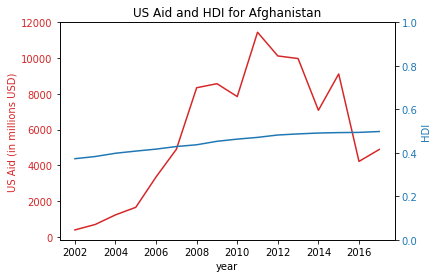

In [64]:
# Plot US data vs. HDI data
def plot_US_HDI(cname):
    t = combined_df_complete[combined_df_complete.country_name.str.match(f'{cname}')].year
    data1 = combined_df_complete[combined_df_complete.country_name.str.match(f'{cname}')].US_Aid
    data3 = combined_df_complete[combined_df_complete.country_name.str.match(f'{cname}')].HDI
    fig, ax1 = plt.subplots()

    color = 'tab:red'

    ax1.set_xlabel('year')
    ax1.set_ylabel('US Aid (in millions USD)', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('HDI', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0, top=1)
    plt.title(f'US Aid and HDI for {cname}')
    plt.savefig(f'Project 1 Images/{cname} - US.png')
    plt.show()


In [65]:
# Plot World Bank Data vs HDI data
def plot_World_HDI(cname):
    t = combined_df_complete[combined_df_complete.country_name.str.match(f'{cname}')].year
    data2 = combined_df_complete[combined_df_complete.country_name.str.match(f'{cname}')].WorldBank_Aid
    data3 = combined_df_complete[combined_df_complete.country_name.str.match(f'{cname}')].HDI

    fig, ax1 = plt.subplots()

    color = 'tab:red'

    ax1.set_xlabel('year')
    ax1.set_ylabel('World Aid (in Millions USD)', color=color)
    ax1.plot(t, data2, color=color)
    ax1.tick_params(axis='y', labelcolor=color, )

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('HDI', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0, top=1)

    plt.title(f'World Aid and HDI for {cname}')
    plt.savefig(f'Project 1 Images/{cname} - World.png')
    plt.show()


In [ ]:
# Line Plot total US aid to countries
usaidtop50_df.fiscal_year = usaidtop50_df.fiscal_year.astype(int)

def show_plot_usaid(cname):
    return usaidtop50_df.query(f'country_name == "{cname}"').groupby('fiscal_year').agg({
        "current_amount": 'sum'
    }).plot(kind='line', title=cname)

show_plot_usaid('Egypt')
show_plot_usaid('Iraq')
show_plot_usaid('Poland')
show_plot_usaid('Haiti')
show_plot_usaid('World')
show_plot_usaid('West Bank/Gaza')
show_plot_usaid('Israel')

In [54]:
#US aid grouped by agency giving aid
aid_by_agency = usaidtop50_df.groupby(['country_name','implementing_agency_name']).agg({
    'current_amount':'sum'
})
aid_by_agency = aid_by_agency.reset_index()

#Rename US agencies to improve readability of graphics
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Department of',"")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Health and Human Services',"HHS")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('U.S. Agency for International Development',"US_AID")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Trade and Development Agency',"TDA")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('the',"")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Environmental Protection Agency',"EPA")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Federal Trade Commission',"FTC")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Homeland Security',"DHS")
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Overseas Private Investment Corporation','OPIC')
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Millennium Challenge Corporation','MCC')
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('National Science Foundation','NSF')
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('African Development Foundation','ADF')
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('United States Institute of Peace','USIP')
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Open World Leadership Center','OWLC')
aid_by_agency.implementing_agency_name = aid_by_agency.implementing_agency_name.str.replace('Inter-American Foundation','I-AF')
aid_by_agency.current_amount = aid_by_agency.current_amount/1000000


array([' Agriculture', ' Commerce', ' Defense', ' Energy', ' HHS', ' DHS',
       ' Justice', ' Labor', ' State', ' Transportation', '  Army',
       '  Treasury', 'TDA', 'US_AID', '  Interior', 'EPA', '  Navy',
       'Peace Corps', 'I-AF', 'MCC', '  Air Force', 'FTC', 'ADF', 'NSF',
       'OWLC', 'OPIC', 'USIP'], dtype=object)

In [55]:
color_dict = {'Agriculture': 'red',
              'Commerce':'green',
              'Defence':'blue',
              'Energy':'yellow',
              'HHS': 'blue',
             'DHS':'orange',
             'Justice':'cyan',
             'Labor':'brown',
             'State':'black',
             'Transportation':'magenta',
              'Army':'silver',
              'Treasury':'grey',
              'TDA':'pink',
            'US_AID':'salmon',
              'Interior':'linen',
              'EPA':'limegreen',
              'Navy':'gold',
              'Peace Corps':'navy',
           'I-AF':'indigo',
              'MCC':'orchid',
           'Air Force':'tan',
              'FTC':'darkred',
              'ADF':'greenyellow',
               'NSF':'teal',
              'OWLC':'olivedrab',
           'OPIC':'slategray',
           'USIP':'tomato'}
aid_by_agency['color_agency'] = aid_by_agency.implementing_agency_name.map(lambda x: color_dict.get(x.strip(), 'purple'))


In [56]:
#Graph US aid by agency for a country
def plot_aid_by_agency(cname):
    dept_names = aid_by_agency.query(f'country_name == "{cname}"')['implementing_agency_name'].to_list()
    aid_filtered = aid_by_agency.query(f'country_name == "{cname}"')   
    aid_filtered.plot(kind = 'bar', x = 'implementing_agency_name',y = 'current_amount', 
                      color = aid_filtered.color_agency,legend = False)
    plt.xlabel('Agency')
    plt.ylabel('Aid (in Millions USD)')
    plt.title(f'Aid by Agency for {cname}')
    print(cname)
    plt.tight_layout()
    plt.savefig(f'Project 1 Images/{cname} - AidByAgency.png')
    plt.show()


World


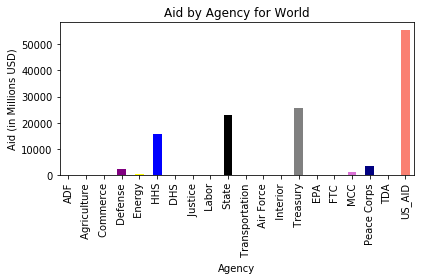

Afghanistan


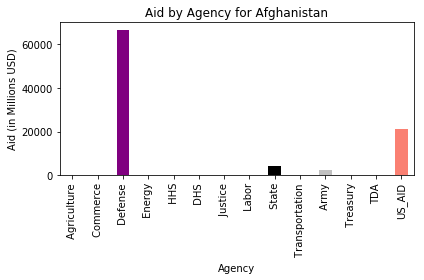

Iraq


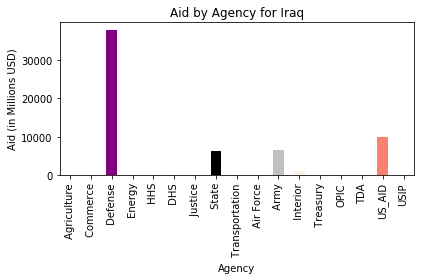

Israel


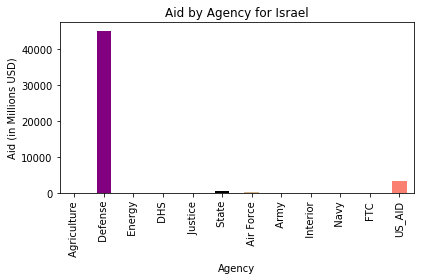

Egypt


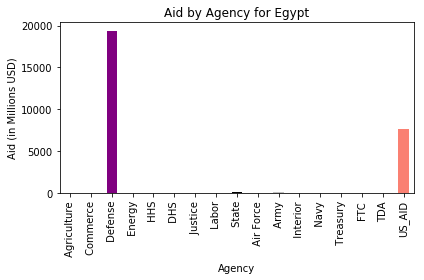

Jordan


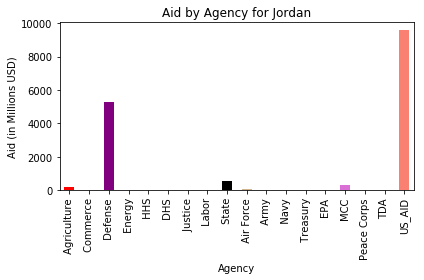

Pakistan


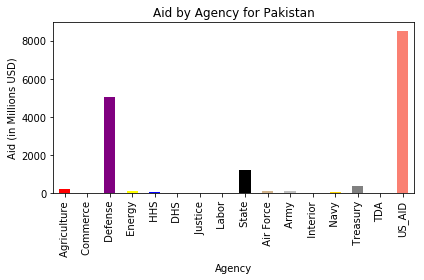

Ethiopia


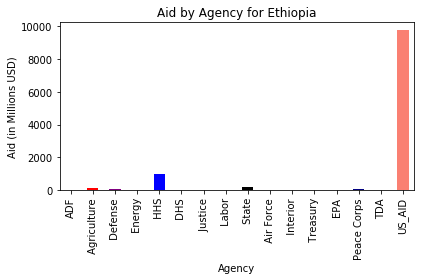

Sub-Saharan Africa Region


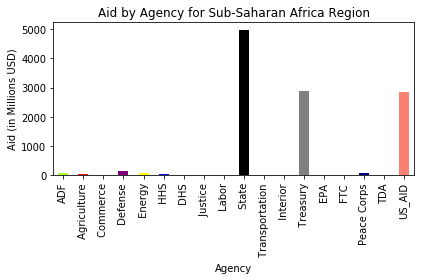

Russia


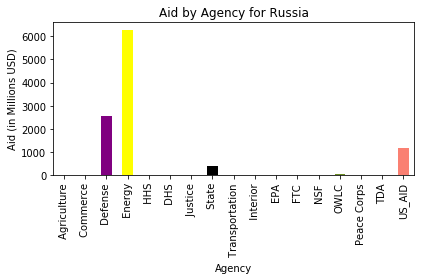

Colombia


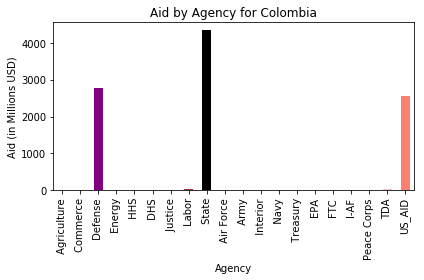

Kenya


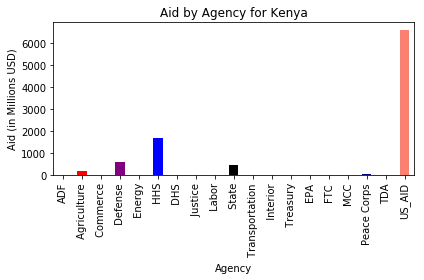

Sudan (former)


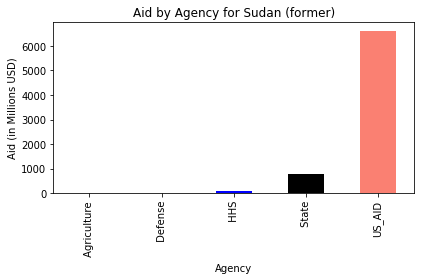

Nigeria


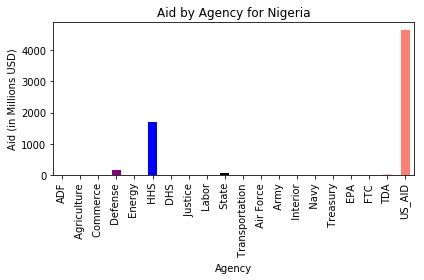

Uganda


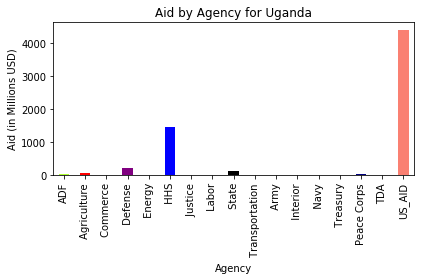

South Africa


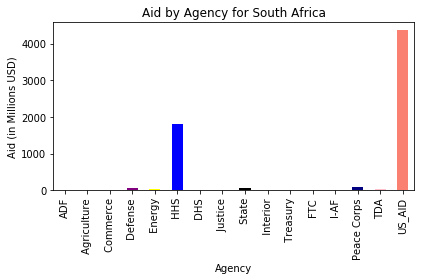

Tanzania


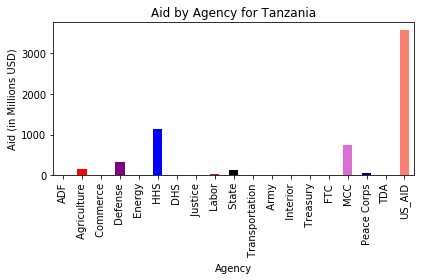

Haiti


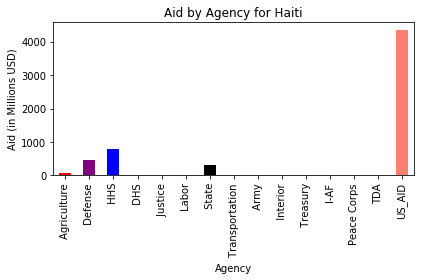

Middle East and North Africa Region


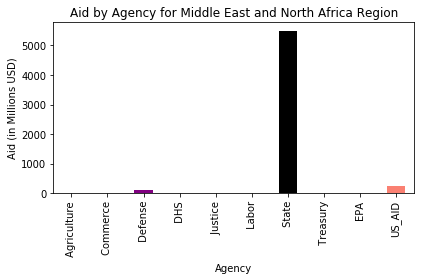

Congo (Kinshasa)


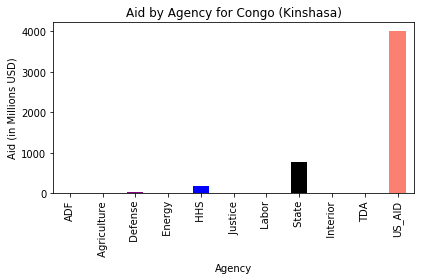

Mozambique


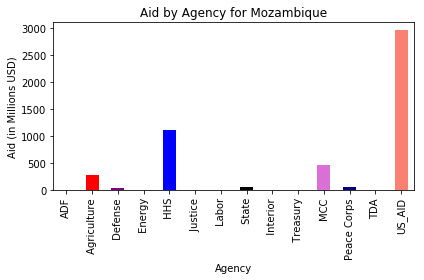

South Sudan


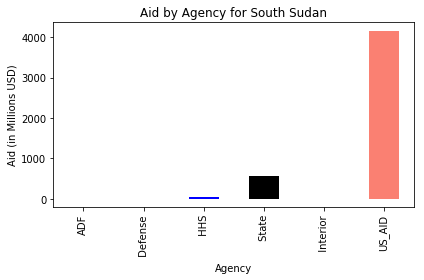

Syria


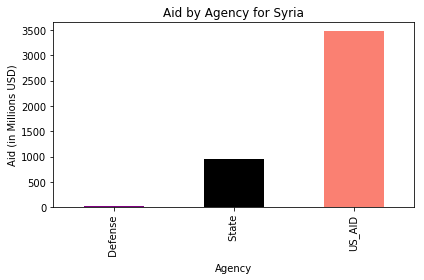

Indonesia


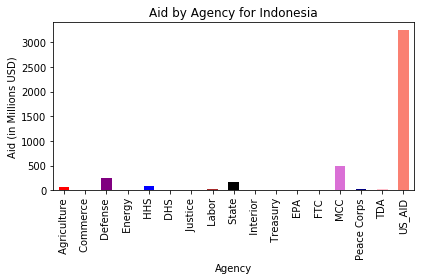

Zambia


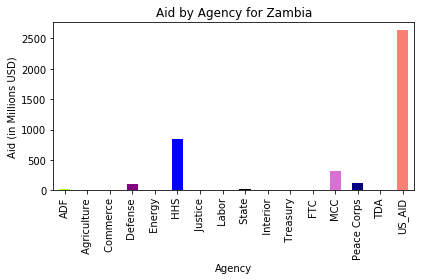

Ukraine


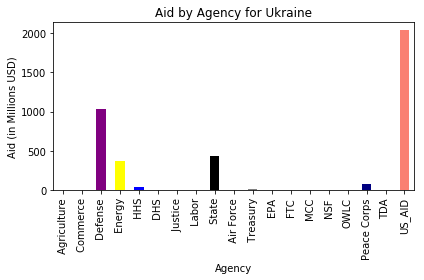

Philippines


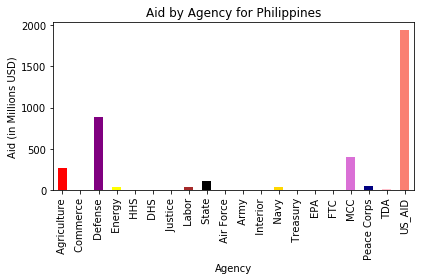

Somalia


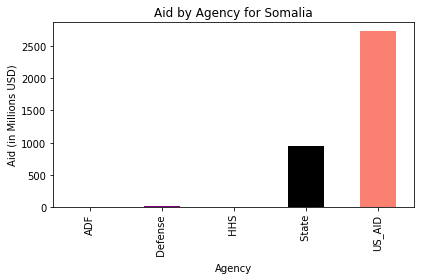

Latin America and Caribbean Region


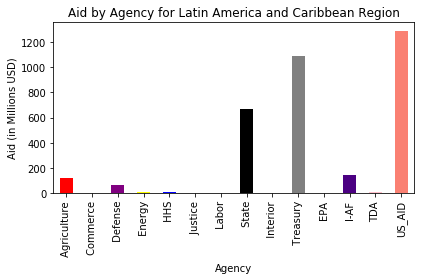

Bangladesh


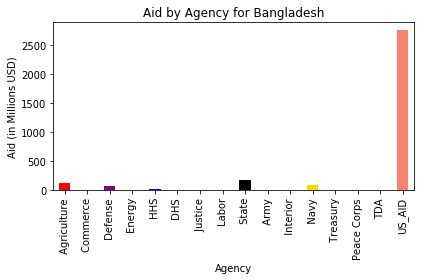

Georgia


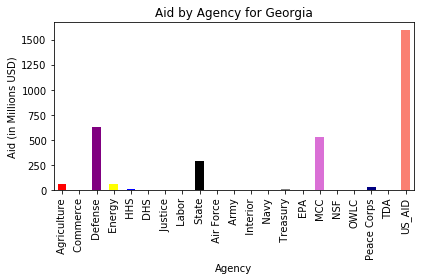

Lebanon


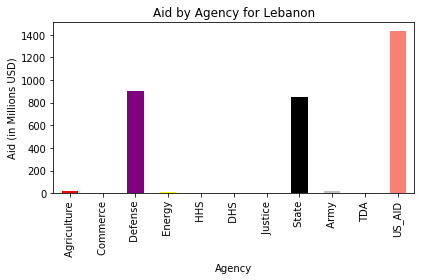

Liberia


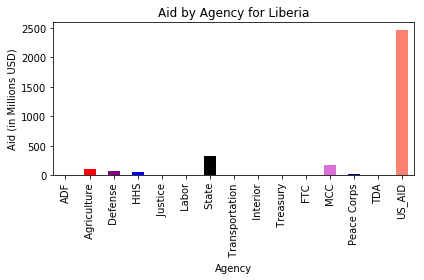

Mexico


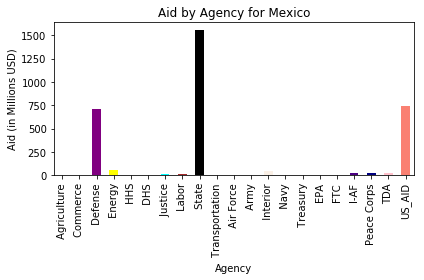

Malawi


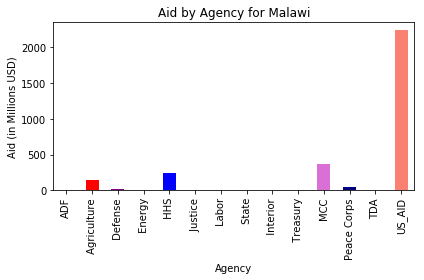

Poland


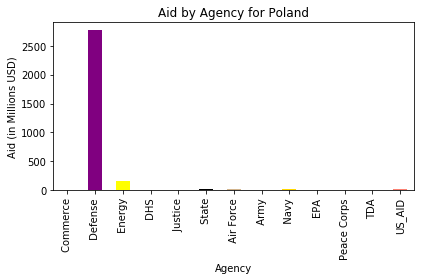

Peru


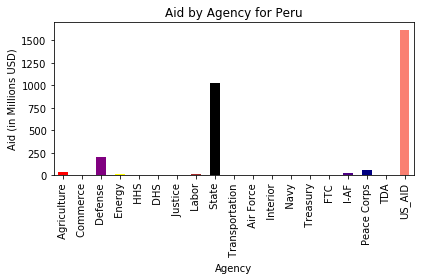

Asia Region


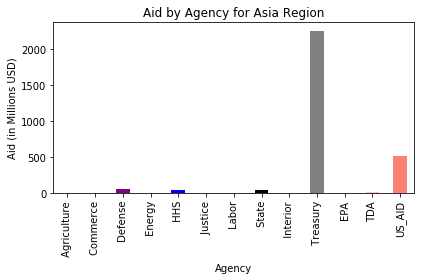

Yemen


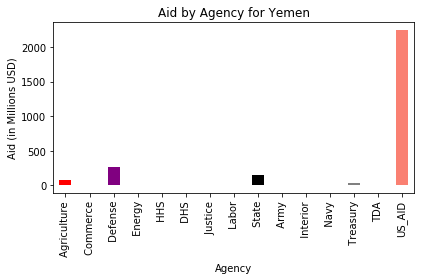

Ghana


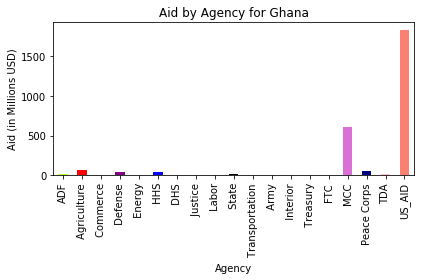

Mali


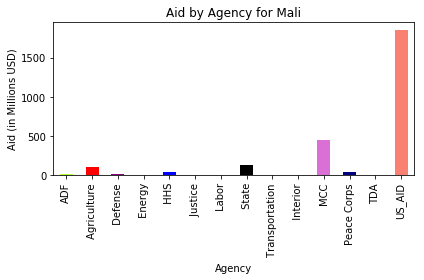

India


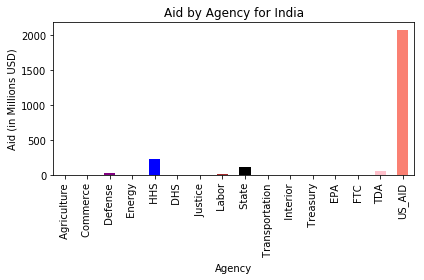

Zimbabwe


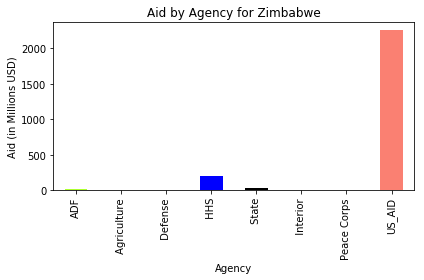

Senegal


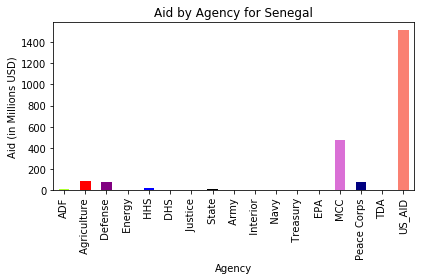

Guatemala


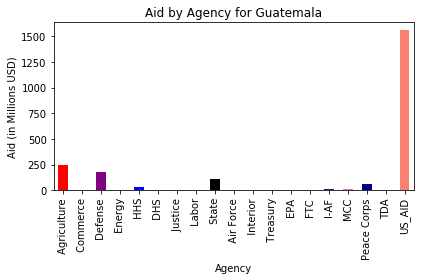

Rwanda


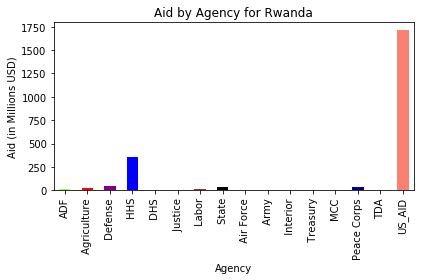

El Salvador


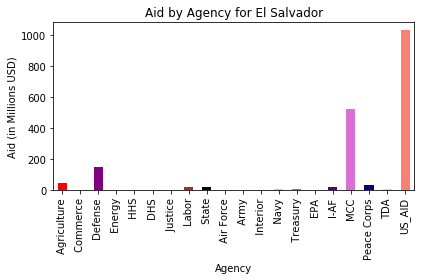

Honduras


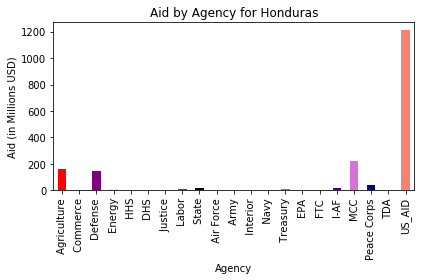

Bolivia


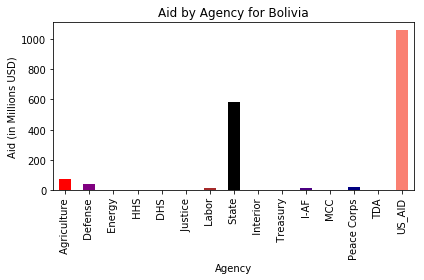

In [67]:
for country in view_list:
    plot_World_HDI(country)
    plot_US_HDI(country)
    plot_aid_by_agency(country)
